# Rigid Body Molecular Dynamics Simulations

## Overview

### Questions

* How do input rigid bodies into hoomd? 
* How do I integrate the rigid bodies in my simulation? 
* In a rigid body molecular dynamics simulation, how are thermodynamic quantities measured?  

### Objectives

* Describe how to add a rigid body to a hoomd simulation. 
    * Mass 
    * Moment of inertia
* Explain how filtering of the rigid body works in hoomd.
* Explain integration of rotational degrees of freedom.
* Show how constituent particles are specified in hoomd.
* Run a rigid body MD simulation at constant temperature.
* Define how quanties like the energy are defined in a rigid body molecular dynamics simulation. 
* Show that thermodynamic quantities (the total translational kinetic energy in our example) are defined in reference to rigid bodies not the constituent particles of the rigid body.

## Boilerplate code

In [1]:
import itertools
import math

import gsd.hoomd
import hoomd
import numpy
import rowan

from hoomd.md import constrain

The `render_rigid_body` and 'render_simulation' are functions in the next (hidden) cell will render the rigid body and render a simulation snapshot (respectively) using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render_rigid_body(pos_body, radius_constituent):
    '''
    outputs the sphere positions in the rigid body depending on the radius of the constituent particles
    '''
    L = 3 * numpy.max(numpy.linalg.norm(pos_body, axis=1))
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(pos_body),
                                       radius=radius_constituent)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = pos_body
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)
    
    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

def render_simulation(radius_constituent,snapshot):
    '''
    Outputs sphere positions based on the trajectory of the simulation
    '''
    wh_sp = numpy.where((snapshot.particles.typeid == 1))
    pos_parts = snapshot.particles.position[wh_sp]
    L = snapshot.configuration.box[0]
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(pos_parts),
                                       radius=radius_constituent)
    geometry.position[:] = pos_parts
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)
    
    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

The previous section outlined the rigid body physics of a dumbell particle of two spheres fused together.  

In [3]:
mass_rigid_body = 2.
inertia_tensor = numpy.array([[0,0,0],[0,2,0],[0,0,2]])
local_position = numpy.array([[1,0,0],[-1,0,0]])

In [4]:
m = 2
N_particles = 2 * m**3
spacing = 10.
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
position = numpy.array(position)
position[:,0] = position[:,0]
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N_particles
snapshot.particles.position = position[0:N_particles,:]
snapshot.particles.orientation = [(1,0,0,0)] * N_particles
snapshot.configuration.box = [L, L, L, 0, 0, 0]

### Property Specifications of the Rigid Body:

Add the properties of the rigid bodies. 

The moment of inertia of a rigid body is defined by an inertia tensor, but it is important to note that HOOMD requires that the rigid body is oriented such that the moment of inertia tensor is *diagonalized*. In the case of the dumbell above this is already the case and the xx,yy, and zz components of the inertia tensor matrix are directly inputed into hoomd. Section 3 of this tutorial covers how to add bodies to hoomd that are oriented in a way that the inertia tensor is not diagonalized.

In [5]:
snapshot.particles.mass = [mass_rigid_body] * N_particles
snapshot.particles.moment_inertia = [(inertia_tensor[0,0],inertia_tensor[1,1],inertia_tensor[2,2])] * N_particles

Define both the rigid body and constituent particle types. Note that the typeid for each particle is only the rigid body id. The constituent particles will be added to the simulation later. 

In [6]:
snapshot.particles.types = ['rigid_body','constituent_sphere']
snapshot.particles.typeid = [0] * N_particles

Write the snapshot to the file system.

In [7]:
with gsd.hoomd.open(name='lattice_rigid.gsd', mode='wb') as f:
    f.append(snapshot)

Create a simulation object and device

In [8]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_gsd(filename='lattice_rigid.gsd')

# How to integrate the rigid bodies:

The process of integrating rigid bodies requires many steps, the basics are listed below. 

* Rigid Body Initialization 

    * Initialize simulation from a snapshot (did this above).
    * Create a cell list that filters out the rigid bodies which are composed of constituent particles
    * Create a **filter** for the integrator that only integrates the rigid bodies 
    * Create a force field for the constituent particles
    * Create an integrator
    * Add a rigid body constraint and define the particles within the rigid body
    * Create particles in the rigid body in the simulation. 
    * Add rigid bodies to the integrator

* Final Setup
    * Give particles random momenta drawn correctly drawn from the Boltzmann distribution for the current temperature
    * Run Simulation at Desired Temperature

* Run the simulation

# Parameters for the Lennard-Jones force field

Each sphere that makes up the dumbell interacts with a Lennard Jones potential that has two parameters:
* $\epsilon$ - The prefactor in front of the LJ potential
* $\sigma$ - Dictates the range of the LJ potential

Assume the radius of the particle is the half the minimum distance between two LJ spheres at minimum pairwise energy. 

$r_m = 2^{1/6}\sigma$

Set $r_m$ to 2 and therefore $\sigma$ equals $2/2^{1/6}$

Set $\epsilon = 1.$

In [9]:
epsilon = 1
sigma = 2/2**(1/6)

# Parameters of the Integrator:

Set integrate the rotational degrees of freedom to True to update the orientation of rigid bodies 

Rigid bodies are often anisotropic and their rotational degrees of freedom need to be integrated to evolve their orientation through time. Hoomd requires the user to explicitly set integration of the rotational degrees of freedom.

In order to only integrate over the rigid bodies and not the constituent particles that make up the body, hoomd uses a filter that tells the integrator to only integrate over the rigid bodies and any other free bodies in the system. This allows the integration to happen for only the rigid bodies. 

In [10]:
integrator = hoomd.md.Integrator(dt=0.0001,integrate_rotational_dof=True)

Make a cell list that excludes the rigid body centers and add a Lennard-Jones potential with the cell list.

In [11]:
cell = hoomd.md.nlist.Cell(buffer=0,exclusions = ['body'])
lj = hoomd.md.pair.LJ(nlist=cell)

Specify all pairwise interactions in the system. Set cutoff radius and epsilon for all interactions besides the constituent particles to be zero.

In [12]:
lj.params[('rigid_body', 'rigid_body')] = dict(epsilon=0, sigma=sigma)
lj.params[('rigid_body', 'constituent_sphere')] = dict(epsilon=0, sigma=sigma)
lj.params[('constituent_sphere', 'constituent_sphere')] = dict(epsilon=epsilon, sigma=sigma)
lj.r_cut[('constituent_sphere', 'constituent_sphere')] = 4 * sigma 
lj.r_cut[('rigid_body', 'rigid_body')] = 0.
lj.r_cut[('rigid_body', 'constituent_sphere')] = 0.
integrator.forces.append(lj)

## Adding rigid body constraint:

This adds the rigid bodies to the simulations and marks them as 'body' type particles. 

In hoomd, the rigid body constraint is added to the integrator.

Requirements of the constraint are:
* A list of constituent particle type names
* A list of constituent particle positions
* A list of constituent particle orientations
* A list of constituent particle charges
* A list of constituent particle diameters

In [13]:
rigid = constrain.Rigid()

constituent_types = ['constituent_sphere','constituent_sphere']

rigid.body['rigid_body'] = {
    "constituent_types": constituent_types,
    "positions":local_position,
    "orientations":[(1,0,0,0)] * len(constituent_types),
    "charges":[0.] * len(constituent_types),
    "diameters":[2.] * len(constituent_types)}

### Creating the constituent particles in simulation:

Create the constituent particles in simulations so that hoomd can sum over the forces of the particles on each rigid body and add the constraint to the integrator. 

In [14]:
rigid.create_bodies(sim.state)
integrator.rigid = rigid

# Filtering integration in hoomd:

Hoomd must filter out the integration of only the rigid bodies and has a built in method to do so.

The rigid body filter is applied to the Nose-Hoover NVT integrator, which maintains a constant temperature for the system. 

*Center* particles are denoted as the rigid body centers defined above. *free* particles are particles that are neither a rigid body center, nor constituent particles of a rigid body.  

In [15]:
temperature = 1.
rigid_centers_and_free_filter = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.NVT(kT = temperature, tau = 1., filter = rigid_centers_and_free_filter)
integrator.methods.append(nvt)
sim.operations.integrator = integrator

Before running the simulation define a logger.

In [16]:
# Gsd writer for simulations
logger = hoomd.logging.Logger(['particle','constraint'])
gsd_oper = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(1000), filename='randomization.gsd',log=logger,mode='wb',dynamic=['momentum','property'])
sim.operations += gsd_oper

## Running a Simulation in Hoomd:

The simulation has now been set up to run and log a rigid body simulation.

## As an example, thermodynamic properties will be computed and saved for the system.

The thermdynamic property compared below will show system wide translational kinetic energy calculated by hoomd matches to the translational kinetic energy calculated from the velocities and masses of the rigid bodies. 

This thereby demonstrates the the thermodynamic quantities of the system are determined by the properties of the rigid bodies (mass, moment of inertia, ect.), and the forces between the constituent particles but the masses of the constituent particles. The constituent particles only define the force field between rigid bodies. 

## Note:
The thermodynamic properties must also be filtered so that they are calculated only over the rigid body centers. This is the same as applying a filter to only integrate the rigid body centers

In [17]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=rigid_centers_and_free_filter)

sim.operations.computes.append(thermodynamic_properties)

Once again, filter by particle type to thermalize only the rigid bodies.

In [18]:
sim.state.thermalize_particle_momenta(filter=rigid_centers_and_free_filter, kT=temperature)

Run the simulation.

In [19]:
sim.run(20000)

In [20]:
thermodynamic_properties.translational_kinetic_energy

29.72003895265531

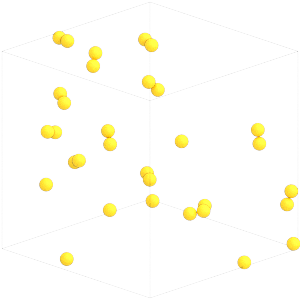

In [21]:
snapshot = gsd.hoomd.open('randomization.gsd')[-1]
render_simulation(1.,snapshot)

In [22]:
# Get the mass and velocity of the rigid bodies
rigid_body = numpy.where(snapshot.particles.typeid == 0)
velocity = snapshot.particles.velocity[rigid_body]
mass = snapshot.particles.mass[rigid_body]

print('translational kinetic energy calculated from velocity and mass of rigid bodies', numpy.sum(.5 * mass * numpy.linalg.norm(velocity,axis=1) ** 2))

translational kinetic energy calculated from velocity and mass of rigid bodies 29.720037


Note that the translational kinetic energy for the rigid bodies is the same as the tranlational kinetic energy calculated for the simulation. 